In [126]:
import nibabel as nib
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as alb
import random
from sklearn.model_selection import KFold

# Globals 

In [127]:
BASE_DIR = "/scratch/users/rjuhl/data/Dataset"
SAVE_DIR = "/home/users/rjuhl/MRI_BC/results"

SIZE = 128
DEPTH = 128

k_folds = 5
epochs = 30
batch_size = 16

# Data preprocessing 

In [128]:
'''
splitDataset goes through the data set and sorts it into two groups: clean images and images
with a motion artifact
'''

def splitDataset():
    clean = []
    art = []
    for file in os.listdir(BASE_DIR):
        if file.startswith('.'):
            continue
        art.append(file) if str(file[0]) != 'N' else clean.append(file)
    return clean, art

'''
getDataset complies a list of all the file names in the dataset 
'''

def getDataset():
    filelist = []
    for file in os.listdir(BASE_DIR):
        if file.startswith('.'):
            continue
        filelist.append(file)
    return filelist

# Helper Funcs

In [129]:
'''
double_conv is a helper function for the model
'''

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, 3, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv3d(out_channels, out_channels, 3, padding=1), 
        nn.LeakyReLU(0.2, inplace=True))

'''
filewriter is used in train() to save information about the model and its predictions
'''

def fileWriter(fold, epoch, train_pre, test_pre, train_acc, test_acc, loss_arr):
    file = open(os.path.join(SAVE_DIR, "Fold#" + str(fold) + "Epoch#" + str(epoch) + "Prediction_and_acc_scores.txt"), 'a')
    file.write(str(fold) + str(epoch) + '\n')
    file.write("-----Training predictions-----\n")
    for t_file in train_pre:
        file.write(str(t_file) + ':' + str(train_pre[t_file]) + '\n')
    file.write("-----Testing predictions-----\n")
    for t_file in test_pre:
        file.write(str(t_file) + ':' + str(test_pre[t_file]) + '\n')
    file.write("-----Training and testing accuracies-----\n")
    file.write("Train Acc:" + str(train_acc) + '\n')
    file.write("Test Acc:" + str(test_acc) + '\n')
    file.write("Loss Arr:" + str(loss_arr) + '\n')
    file.write("----- END -----\n")
    file.close()

'''
reset_weights is a helper function I got from: 
https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/
reset_weights is called before each fold is trained to reset the model weights
'''    

def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

# Dataset

In [130]:
'''
MRIDataset creates the dataset. Labeling and resizing each image appropriately. 
'''

class MRIDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img = nib.load(os.path.join(BASE_DIR, self.files[index]))
        img_data = torch.squeeze(torch.from_numpy(np.array(img.get_fdata())))

        resize = alb.Resize(width=SIZE, height=SIZE, p=1.0)
        cur_depth = img_data.size()[2]
        pad = (cur_depth - DEPTH) // 2
        idx = range(pad, pad + DEPTH)
        img_data = resize(image=img_data[:, :, idx].numpy())['image']
        img_data = torch.tensor(img_data)

        def normalize(i):
            return (i - torch.min(i)) / (torch.max(i) - torch.min(i))

        img_data = normalize(img_data)
        val = 0 if self.files[index][0] == 'N' else 1

        return img_data.unsqueeze(0).float(), val, self.files[index]

    def labels(self):
        labels = []
        for file in self.files:
            val = 0 if file[0] == 'N' else 1
            labels.append(val)
        return np.array(labels)

# The model

In [131]:
'''
the model is the same as Ana's regression model. Later it is converted as a Binary Classifier by the 
use of the BCEWithLogitsLoss() loss function
'''

class Net(nn.Module):
    def __init__(self):
        # 128x128x128
        super(Net, self).__init__()
        self.conv_down1 = double_conv(1, 32)
        self.conv_down2 = double_conv(32, 64)
        self.conv_down3 = double_conv(64, 128)
        self.conv_down4 = double_conv(128, 256)
        self.maxpool = nn.MaxPool3d((2, 2, 2))
        self.fc1 = nn.Linear(16 * 16 * 16 * 256, 1)

    def forward(self, x):
        x = x.half()
        conv1 = self.conv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.conv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.conv_down3(x)
        x = self.maxpool(conv3)
        x = self.conv_down4(x)
        x = x.view(-1, 16 * 16 * 16 * 256)
        x = self.fc1(x)
        return x

# Training

In [132]:
'''
Trains the model. It also saves prediction information and accuracies for the each fold and epoch
'''

def train():
    dataset = MRIDataset(getDataset())
    kfold = StratifiedKFold(k_folds, shuffle=True, random_state=2018)

    device = torch.device('cuda:0,1,2,3' if torch.cuda.is_available() else 'cpu')
    model = Net()
    # summary(model, (1, 128, 128, 128))
    model = model.half()

    # Train model on 4 GPUs
    model.cuda()
    model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
    model.to(device)

    # Calculate weight
    clean, art = splitDataset()
    weight = len(clean) / len(art)
    # weight ~5. Setting pos_weight = weight should increase recall so that false negatives go down
    weight = torch.tensor([weight]).to(device)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=weight)

    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset, dataset.labels())):
        print(f'Fold: {fold}\n\n')

        train_subsamples = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsamples = torch.utils.data.SubsetRandomSampler(test_ids)

        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                   num_workers=2, sampler=train_subsamples)
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                  num_workers=2, sampler=test_subsamples)

        # Need to reset optimizer and model params
        model.apply(reset_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, eps=1e-4)

        # Train the fold
        for epoch in range(epochs):
            model.train()

            # prediction for each file in the training set and test set + loss array 
            train_pre = {}
            test_pre = {}
            loss_arr = []

            # Correct prediction count for the train set and test set
            train_count = 0
            test_count = 0

            for i, (inp, target, file) in enumerate(train_loader):
                # Send inp and target to device (GPU)
                inp = inp.half().to(device)
                target = target.half().to(device)

                optimizer.zero_grad()
                cur_pre = model(inp)
                loss = loss_func(cur_pre, target.unsqueeze(1).float())
                loss_arr.append(loss.item())

                # Since it is regression model until BCELogitLoss applies the sig func we need to apply sig func
                # if we want to accurately count correct predictions
                sig = nn.Sigmoid()
                sig_pre = sig(cur_pre).detach()

                for i in range(len(file)):
                    train_pre[str(file[i])] = cur_pre[i].detach()

                    if (target[i] == 1 and sig_pre[i] > 0.5) or (target[i] == 0 and sig_pre[i] < 0.5):
                        train_count += 1

                loss.backward()
                optimizer.step()

            with torch.no_grad():
                for i, (inp, target, file) in enumerate(test_loader):
                    # Send inp and target to device (GPU)
                    inp = inp.half().to(device)
                    target = target.half().to(device)

                    cur_pre = model(inp)

                    sig = nn.Sigmoid()
                    sig_pre = sig(cur_pre)

                    for i in range(len(file)):
                        test_pre[str(file[i])] = cur_pre[i]

                        if (target[i] == 1 and sig_pre[i] > 0.5) or (target[i] == 0 and sig_pre[i] < 0.5):
                            test_count += 1

            # Calculate train and test accuracies
            train_acc = train_count / len(train_pre)
            test_acc = test_count / len(test_pre)

            # Record prediction and accuracies
            fileWriter(fold, epoch, train_pre, test_pre, train_acc, test_acc, loss_arr)

            print(f'Epoch: {epoch} finished!')

        # Save model
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, os.path.join(SAVE_DIR, 'Fold#' + str(fold) + 'Model.pth'))

        print(f'Fold {fold} completed!')

# More Helper Functions (for results and graphs)

In [133]:
RES_DIR = "/Users/rainjuhl/PycharmProjects/MRI_BC_Project/results"

In [134]:
'''
fileParser parses the result files and returns the recorded predictions and accuracies 
'''

def fileParser(fold, epoch, type='Testing'):
    predictions = []
    accuracy = []

    file = open(os.path.join(RES_DIR, f"Fold#{fold}Epoch#{epoch}Prediction_and_acc_scores.txt"), 'r')
    while file.readline() != f"-----{type} predictions-----\n": continue

    def sigScore(val):
        sig = nn.Sigmoid()
        val = torch.tensor([float(val)])
        return sig(val).item()

    while True:
        line = file.readline()
        if line[0] == '-':
            break
        name = line[0:line.find(':')]
        score = line[line.find(':') + 9:line.find(',') - 1]
        score = sigScore(score)
        prediction = [name, score]
        predictions.append(prediction)

    while True:
        line = file.readline()
        if line[0:9] == "Train Acc":
            accuracy.append(float(line[line.find(':') + 1:]))
        if line[0:8] == "Test Acc":
            accuracy.append(float(line[line.find(':') + 1:]))
        if line == '':
            break

    file.close()
    return predictions, accuracy

'''
predAndTar creates an array for the predictions of a particular epoch of a particular fold. It 
also returns a targets array for the epoch/fold
'''

def predAndTar(fold, epoch):
    predictions, _ = fileParser(fold, epoch, "Testing")
    targets = []
    pre_nums = []
    for prediction in predictions:
        if prediction[0][0] == 'N':
            targets.append(0.0)
        else:
            targets.append(1.0)
    for prediction in predictions:
        pre_nums.append(float(prediction[1]))
    return pre_nums, targets

'''
calcSensAndSpec returns two arrays. The first is the sensitivity for each epoch of a specified fold.
The second returns the specificity for each epoch of specified fold. 
'''

def calcSensAndSpec(fold, epochs, numFold=1):
    sens_arr = []
    spec_arr = []
    for epoch in range(epochs):
        pre_nums = []
        targets = []
        if numFold == 1:
            pre_nums, targets = predAndTar(fold, epoch)
        else:
            for curfold in range(numFold):
                pres, tar = predAndTar(curfold, epoch)
                for i in range(len(pres)):
                    pre_nums.append(pres[i])
                    targets.append(tar[i])
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for i in range(len(targets)):
            if targets[i] == 0:
                if pre_nums[i] < 0.5:
                    TN += 1
                else:
                    FP += 1
            else:
                if pre_nums[i] < 0.5:
                    FN += 1
                else:
                    TP += 1
        sens_arr.append(TP / (TP + FN))
        spec_arr.append(TN / (TN + FP))
    return sens_arr, spec_arr

'''
filetype return whether or not the img has motion and then the site it came from (A, B, C, D, or E)
'''

def filetype(file):
    if file[0] == 'N':
        return False, file[-8]
    else:
        return True, file[0]
    
'''
getSiteArr is a helper function for boxplot. It helps to organize the data to make it usable
'''

def getSiteArr(folds, epochs, site):
    cpos_arr = []
    apos_arr = []
    for fold in range(folds):
        predictions, _ = fileParser(fold, epochs)
        c_arr = []
        a_arr = []
        for prediction in predictions:
            if filetype(prediction[0])[1] == site:
                if filetype(prediction[0])[0]:
                    a_arr.append(prediction[1])
                else:
                    c_arr.append(prediction[1])
        cpos_arr.append(c_arr)
        apos_arr.append(a_arr)
    return cpos_arr, apos_arr

'''
Helper function for the combined boxplot graph. It initializes the dict correctly.
'''

def intailizeDict(key, dict):
    if key not in dict:
        dict[key] = []

# Results and Graphs 

In [135]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

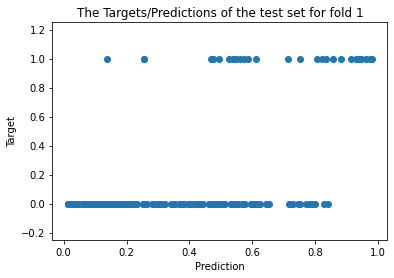

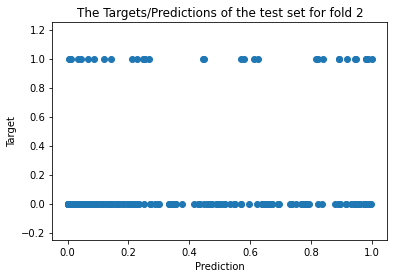

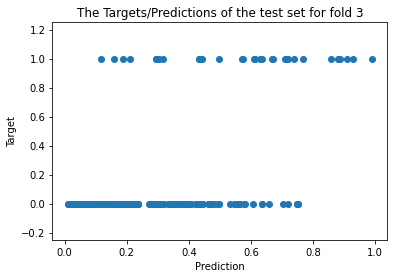

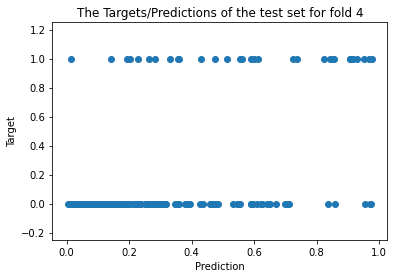

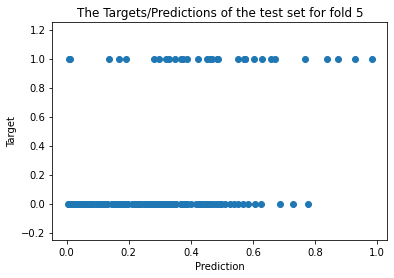

In [136]:
def predictionGraphT2(fold):
    plt.title("The Targets/Predictions of the test set for fold " + str(fold + 1))
    pre_nums, targets = predAndTar(fold, 29)
    plt.scatter(pre_nums, targets)
    plt.ylabel("Target")
    plt.xlabel("Prediction")
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, -0.25, 1.25))
    plt.show()

predictionGraphT2(0)
predictionGraphT2(1)
predictionGraphT2(2)
predictionGraphT2(3)
predictionGraphT2(4)

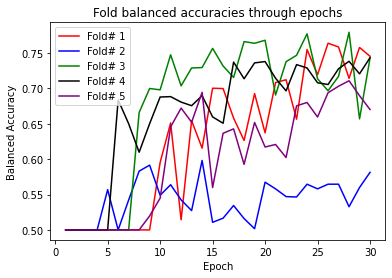

In [137]:
def bAccGraph(folds, epochs):
    plt.title("Fold balanced accuracies through epochs")
    colors = ['red', 'blue', 'green', 'black', 'purple']
    for fold in range(folds):
        sens, spec = calcSensAndSpec(fold, epochs)
        bAcc = []
        epoch_nums = []
        for i in range(len(sens)):
            bAcc.append((sens[i] + spec[i]) / 2)
        for epoch in range(epochs):
            epoch_nums.append(1 + epoch)
        plt.plot(epoch_nums, bAcc, color=colors[fold], label=f'Fold# {fold + 1}')
    plt.legend(loc='upper left')
    plt.ylabel("Balanced Accuracy")
    plt.xlabel("Epoch")
    plt.show()

bAccGraph(5, 30)

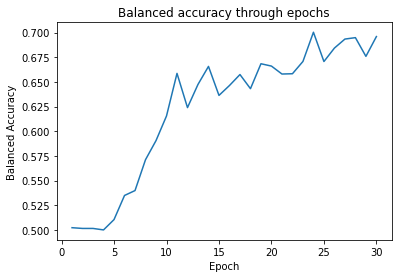

In [138]:
def combinedBAccGraph(folds, epochs):
    bAcc = []
    epoch_nums = []
    sens, spec = calcSensAndSpec(0, epochs, folds)
    for i in range(len(sens)):
        bAcc.append((sens[i] + spec[i]) / 2)
    for epoch in range(epochs):
        epoch_nums.append(1 + epoch)
    plt.title("Balanced accuracy through epochs")
    plt.plot(epoch_nums, bAcc)
    plt.ylabel("Balanced Accuracy")
    plt.xlabel("Epoch")
    plt.show()

combinedBAccGraph(5, 30)

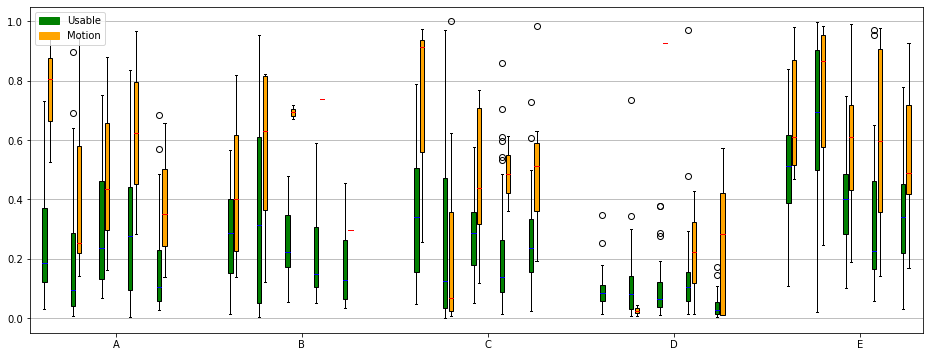

In [139]:
def typeBoxplot(folds, epochs):
    last_pos = 0
    tick_arr = []
    labels = ['A', 'B', 'C', 'D', 'E']
    plt.figure(figsize=(16, 6))
    for item in range(len(labels)):
        cdata, adata = getSiteArr(folds, epochs, labels[item])
        fstart_pos = last_pos
        for i in range(len(cdata)):
            plt.boxplot(cdata[i], positions=[last_pos], patch_artist=True,
                        boxprops=dict(facecolor='green', color='black'), medianprops=dict(color='blue'))
            plt.boxplot(adata[i], positions=[last_pos + .2], patch_artist=True,
                        boxprops=dict(facecolor='orange', color='black'), medianprops=dict(color='red'))
            last_pos += 1
        tick = fstart_pos + ((last_pos - fstart_pos) / 2)
        tick_arr.append(tick)
        last_pos += 1.5
    plt.xticks(tick_arr, labels)
    axes = plt.gca()
    axes.yaxis.grid()
    usable = mpatches.Patch(color='green', label='Usable')
    motion = mpatches.Patch(color='orange', label='Motion')
    plt.legend(handles=[usable, motion], loc='upper left')
    plt.show()

typeBoxplot(5, 29)

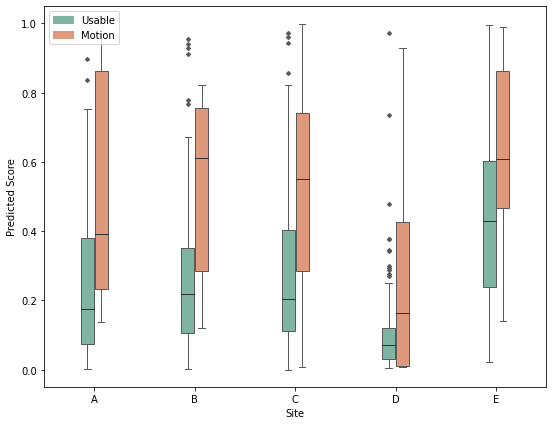

In [140]:
def combinedBoxplot(folds, epoch):
    usableDict = {}
    motionDict = {}
    sites = ['A', 'B', 'C', 'D', 'E']
    plt.figure(figsize=(9, 7))
    for fold in range(folds):
        predictions, _ = fileParser(fold, epoch)

        for prediction in predictions:
            type, site = filetype(prediction[0])
            if type:
                intailizeDict(site, motionDict)
                motionDict[site].append(prediction[1])
            else:
                intailizeDict(site, usableDict)
                usableDict[site].append(prediction[1])

    position = 0
    xticks = []
    for key in sites:
        plt.boxplot(usableDict[key], positions=[position], patch_artist=True,
                        boxprops=dict(facecolor='#80B4A2', color='#595959'), medianprops=dict(color='#303030'),
                        capprops=dict(color='#595959'), whiskerprops=dict(color='#595959'),
                        flierprops=dict(marker='D', markersize='3', color='#595959',
                        markerfacecolor='#595959', markeredgecolor='#595959'))
        plt.boxplot(motionDict[key], positions=[position + .16], patch_artist=True,
                        boxprops=dict(facecolor='#DE987B', color='#595959'), medianprops=dict(color='#303030'),
                        capprops=dict(color='#595959'), whiskerprops=dict(color='#595959'),
                        flierprops=dict(marker='D', markersize='3', color='#595959',
                        markerfacecolor='#595959', markeredgecolor='#595959'))
        xticks.append(position + .08)
        position += 1.16
    plt.xticks(xticks, sites)
    usable = mpatches.Patch(color='#80B4A2', label='Usable')
    motion = mpatches.Patch(color='#DE987B', label='Motion')
    plt.legend(handles=[usable, motion], loc='upper left')
    plt.ylabel("Predicted Score")
    plt.xlabel("Site")
    plt.show()
    
combinedBoxplot(5, 29)